推荐引擎可能是最为流行和出名的机器学习应用了。虽然我们现在知道机器学习领域其实还有很多子方向，推荐引擎只是其中之一，不过这确实从一个角度说明推荐引擎的流行之广。  
推荐引擎在现代生活中几乎无处不在：购物推荐、旅游产品推荐、歌曲/电影推荐、书籍推荐、餐厅推荐等等。  
   
推荐引擎之所以这么普遍，最主要的原因在于：
1. **易于实现**  
    推荐引擎很容易跟现存系统结合。最主要的工作就是收集关于用户趋势、行为模式的数据。  
2. **有效果**  
    其实对于我们之前讨论的其他机器学习算法而言，这也是正确的。不过对于推荐产品的形态而言，它的负向影响更加有限。比如说一个旅游门户网站，它根据它的数据集向用户推荐最热门的目的地。对应的推荐系统可以非常简单，但它出现在用户面前却非常有可能让用户产生兴趣。公司当然可以通过开发更加复杂的推荐引擎来获取更多的收益，但通常，非常简单的推荐引擎也可以收到不错的效果。这一点使得推荐引擎非常吸引人。  
     
     
这里我们使用的数据集被称为"百万歌曲数据库"(The million song dataset)。我们将基于这个数据集，为用户推荐他们可能感兴趣的歌曲。  在这个案例中，我们会实现几种不同复杂度的推荐引擎，它们都是目前工业界使用得最为广泛的推荐技术。

## 百万歌曲数据库
百万歌曲数据量可以在[https://labrosa.ee.columbia.edu/millionsong/](https://labrosa.ee.columbia.edu/millionsong/) 上下载。原始的数据包含了多年间上百万首歌曲的量化音频特征。它实际上是[The Echonest](http://the.echonest.com/)和[LABRosa](http://labrosa.ee.columbia.edu/)的一个合作项目。  
这里我们不会使用整个数据集，而只会使用它们中的一部分。  
基于这个数据库，还衍生出了一些其他的数据集。其中一个就是The Echonest喜好画像子集。这个数据包含了匿名用户的歌曲播放次数的记录。这个数据集即使只是百万歌曲数据库的一个子集，但它的数据量也非常庞大，因为它包含了4800万行三元组信息：  
$$(user id, song id, play counts)$$  
这个数据大概包含了100万用户对384,000首歌的播放记录。  
大家可以通过[http://labrosa.ee.columbia.edu/millionsong/sites/default/files/challenge/train_triplets.txt.zip](http://labrosa.ee.columbia.edu/millionsong/sites/default/files/challenge/train_triplets.txt.zip.)来下载。这个压缩文件大约500MB，解压后大约3.5GB。

## 数据探索
### 加载&裁剪数据
对于我们单机工作而言，这个数据太大了。但是如果是商用服务器，即使是单台机器，它能处理的数据量也要比这大得多，更不用说如果拥有集群计算能力的大型公司了。  
不过，对于我们在现实工作中，我们也是常常从大数据量中抽取一些数据来在单机上进行分析、建模，这样做主要是数据量小的时候各种操作都非常快，同时也能验证我们想要做的事情是不是可行。  
所以，在这里，我们也需要把数据进行一定的裁剪：

In [1]:
import pandas as pd
import numpy as np
import time
import sqlite3 #内存型的mysql

import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab


%matplotlib inline

In [2]:
triplet_dataset = pd.read_csv(filepath_or_buffer='./data/train_triplets.txt', 
                              nrows=10000,sep='\t', header=None, 
                              names=['user','song','play_count']) # 添加表头，数据本身没有表头

In [3]:
triplet_dataset.head()

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


对于这样规模大小的数据集，我们首先要做的是有多少用户(或者歌曲)是我们应该要考虑的。在原始数据集中，有大约100万的用户，但是这里面是不是所有用户我们都需要纳入考虑呢？比如说，如果20%的用户的歌曲播放了占了80%的总体播放量，那么其实我们只需要考虑这20%用户就差不多了。  
    
一般来说，我们统计一下播放量的累积求和就可以知道多少用户占了80%的总体播放量。不过鉴于数据量如此之大，pandas提供的累积求和功能会出问题。所以我们必须自己一行行地读取这个文件，一部分一部分地来完成这项工作：

In [4]:
output_dict = {}
with open('./data/train_triplets.txt') as f:
    for line_number, line in enumerate(f):  #返回一个数据和数据的下标
        user = line.split('\t')[0]     #制表符为分割符
        play_count = int(line.split('\t')[2])
        if user in output_dict:
            play_count +=output_dict[user]
            output_dict.update({user:play_count})
        output_dict.update({user:play_count})
output_list = [{'user':k,'play_count':v} for k,v in output_dict.items()]
play_count_df = pd.DataFrame(output_list)   #把列表转化成数据框
play_count_df = play_count_df.sort_values(by = 'play_count', ascending = False)

play_count_df.to_csv(path_or_buf='./data/user_playcount_df.csv', index = False)

In [5]:
play_count_df = pd.read_csv('./data/user_playcount_df.csv')
play_count_df.head()

,play_count,user
0,13132,093cb74eb3c517c5179ae24caf0ebec51b24d2a2
1,9884,119b7c88d58d0c6eb051365c103da5caf817bea6
2,8210,3fa44653315697f42410a30cb766a4eb102080bb
3,7015,a2679496cd0af9779a92a13ff7c6af5c81ea8c7b
4,6494,d7d2d888ae04d16e994d6964214a1de81392ee04


In [6]:
output_dict = {}
with open('./data/train_triplets.txt') as f:
    for line_number, line in enumerate(f):
        song = line.split('\t')[1]
        play_count = int(line.split('\t')[2])
        if song in output_dict:
            play_count +=output_dict[song]
            output_dict.update({song:play_count})
        output_dict.update({song:play_count})
output_list = [{'song':k,'play_count':v} for k,v in output_dict.items()]
song_count_df = pd.DataFrame(output_list)
song_count_df = song_count_df.sort_values(by = 'play_count', ascending = False)

song_count_df.to_csv(path_or_buf='./data/song_playcount_df.csv', index = False)

In [7]:
song_count_df = pd.read_csv(filepath_or_buffer='./data/song_playcount_df.csv')
song_count_df.head()

,play_count,song
0,726885,SOBONKR12A58A7A7E0
1,648239,SOAUWYT12A81C206F1
2,527893,SOSXLTC12AF72A7F54
3,425463,SOFRQTD12A81C233C0
4,389880,SOEGIYH12A6D4FC0E3


根据这两份数据，统计前多少用户占了40%的总体播放量  
    
就我们这个数据集，大约前100,000用户的播放量占据了总体的40%。

In [8]:
total_play_count = sum(song_count_df.play_count)   #总的歌曲播放量
print(float(play_count_df.head(n=100000).play_count.sum())/total_play_count*100)

play_count_subset = play_count_df.head(n=100000)

40.8807280500655


同样的，我们发现大约35,000首歌占据了总体80%的播放量。这个信息就很有价值：10%的歌曲占据了80%的播放量。  
那么，通过这样一些条件，我们就可以从原始的数据集中抽取出最具代表性的数据出来，从而使得需要处理的数据量在一个可控的范围内。

In [9]:
print(float(song_count_df.head(n=35000).play_count.sum())/total_play_count*100)

song_count_subset = song_count_df.head(n=35000)

80.8849404741813


In [10]:
# 目标用户集和目标歌曲集
user_subset = list(play_count_subset.user)
song_subset = list(song_count_subset.song)

In [11]:
triplet_dataset = pd.read_csv(filepath_or_buffer='./data/train_triplets.txt',sep='\t', 
                              header=None, names=['user','song','play_count'])

# 抽取目标用户
triplet_dataset_sub = triplet_dataset[triplet_dataset.user.isin(user_subset) ]
del(triplet_dataset)

# 过滤非目标歌曲
triplet_dataset_sub_song = triplet_dataset_sub[triplet_dataset_sub.song.isin(song_subset)]
del(triplet_dataset_sub)

triplet_dataset_sub_song.to_csv('./data/triplet_dataset_sub_song.csv', index=False)


In [12]:
triplet_dataset_sub_song = pd.read_csv(filepath_or_buffer='./data/triplet_dataset_sub_song.csv')

In [13]:
triplet_dataset_sub_song.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11235065 entries, 0 to 11235064
Data columns (total 3 columns):
user          object
song          object
play_count    int64
dtypes: int64(1), object(2)
memory usage: 257.2+ MB


### 额外信息
我们前面加载的数据仅仅是三元组数据，我们既不知道歌曲的名称，也不知道歌手的名字，连专辑的名字都不知道。不过这份数据集其实也额外提供了这些歌曲相关的其他信息，比如歌曲名称、演唱者的名称、专辑名称等等。这份数据以SQLite数据库文件形式提供。原始的下载链接为：[http://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/track_metadata.db](http://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/track_metadata.db)

In [14]:
conn = sqlite3.connect('./data/track_metadata.db')
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
cur.fetchall()

[('songs',)]

In [15]:
track_metadata_df = pd.read_sql(con=conn, sql='select * from songs')

#只要3.5万首歌曲中的音乐信息
track_metadata_df_sub = track_metadata_df[track_metadata_df.song_id.isin(song_subset)]

In [16]:
track_metadata_df_sub.shape

(35476, 14)

In [17]:
track_metadata_df_sub.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
47,TRMMMFG128F425087B,Scream,SOWWQXA12A81C1F9CA,Devil's Playground,AR4T2IF1187B9ADBB7,47c8f88b-987a-4b64-9175-2b1b57809727,Billy Idol,282.93179,0.820222,0.485105,2005,3060170,-1,0
115,TRMMGCB128E079651D,Get Along (Feat: Pace Won) (Instrumental),SOHNWIM12A67ADF7D9,Charango,ARU3C671187FB3F71B,067102ea-9519-4622-9077-57ca4164cfbb,Morcheeba,227.47383,0.819087,0.533117,2002,185967,-1,0
123,TRMMGTX128F92FB4D9,Viejo,SOECFIW12A8C144546,Caraluna,ARPAAPH1187FB3601B,f69d655c-ffd6-4bee-8c2a-3086b2be2fc6,Bacilos,307.51302,0.595554,0.400705,0,6825058,-1,0
145,TRMMGDP128F933E59A,I Say A Little Prayer,SOGWEOB12AB018A4D0,The Legendary Hi Records Albums_ Volume 3: Ful...,ARNNRN31187B9AE7B7,fb7272ba-f130-4f0a-934d-6eeea4c18c9a,Al Green,133.58975,0.779490,0.599210,1978,5211723,-1,11898
172,TRMMHBF12903CF6E59,At the Ball_ That's All,SOJGCRL12A8C144187,Best of Laurel & Hardy - The Lonesome Pine,AR1FEUF1187B9AF3E3,4a8ae4fd-ad6f-4912-851f-093f12ee3572,Laurel & Hardy,123.71546,0.438709,0.307120,0,8645877,-1,0


In [18]:
# merge数据
del(track_metadata_df_sub['track_id'])
del(track_metadata_df_sub['artist_mbid'])
track_metadata_df_sub = track_metadata_df_sub.drop_duplicates(['song_id'])
triplet_dataset_sub_song_merged = pd.merge(triplet_dataset_sub_song, track_metadata_df_sub, 
                                           how='left', left_on='song', right_on='song_id')
triplet_dataset_sub_song_merged.rename(columns={'play_count':'listen_count'},inplace=True)

In [19]:
# 删除无用字段
del(triplet_dataset_sub_song_merged['song_id'])
del(triplet_dataset_sub_song_merged['artist_id'])
del(triplet_dataset_sub_song_merged['duration'])
del(triplet_dataset_sub_song_merged['artist_familiarity'])
del(triplet_dataset_sub_song_merged['artist_hotttnesss'])
del(triplet_dataset_sub_song_merged['track_7digitalid'])
del(triplet_dataset_sub_song_merged['shs_perf'])
del(triplet_dataset_sub_song_merged['shs_work'])

In [20]:
triplet_dataset_sub_song_merged.head()

,user,song,listen_count,title,release,artist_name,year
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,You And Me Jesus,Tribute To Jake Hess,Jake Hess,2004
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,Harder Better Faster Stronger,Discovery,Daft Punk,2007
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,Uprising,Uprising,Muse,0
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,Breakfast At Tiffany's,Home,Deep Blue Something,1993
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,Lucky (Album Version),We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0


In [21]:
# 为后面重复使用
triplet_dataset_sub_song_merged.to_csv('./data/triplet_dataset_sub_song_merged.csv',
                                       encoding='utf-8', index=False)

### 最流行的歌曲

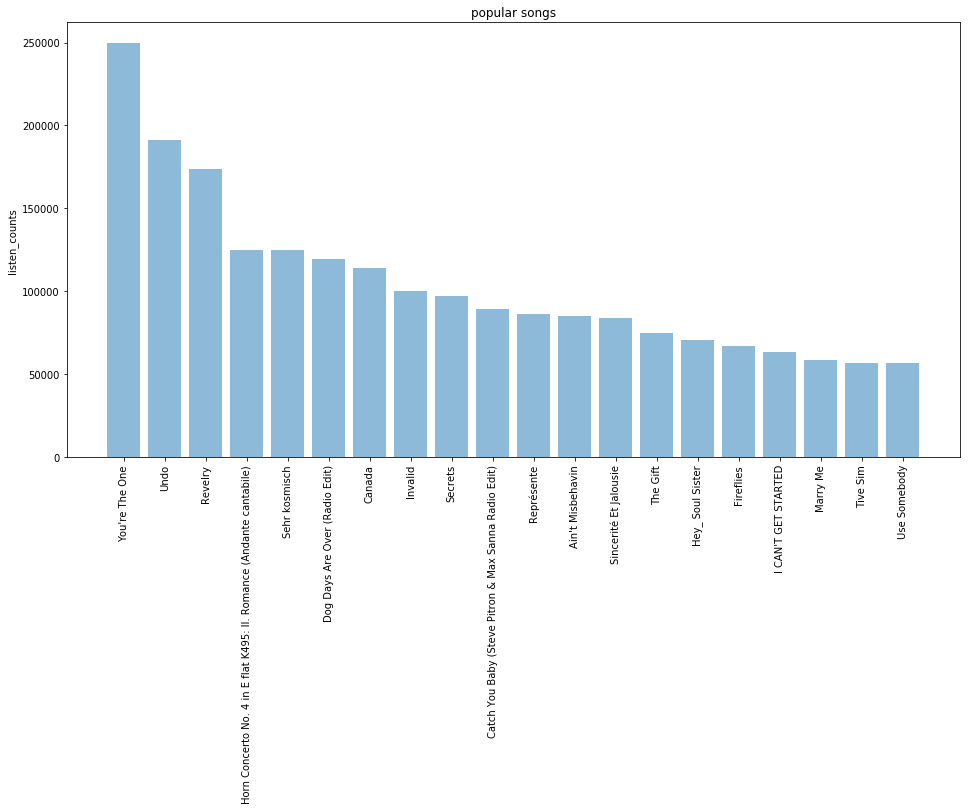

In [22]:
popular_songs = triplet_dataset_sub_song_merged[['title','listen_count']].groupby('title').sum().reset_index()
popular_songs_top_20 = popular_songs.sort_values('listen_count', ascending=False).head(n=20)
 
objects = (list(popular_songs_top_20['title']))
y_pos = np.arange(len(objects))
performance = list(popular_songs_top_20['listen_count'])

plt.figure(figsize=(16,8)) 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('listen_counts')
plt.title('popular songs')
 
plt.show()

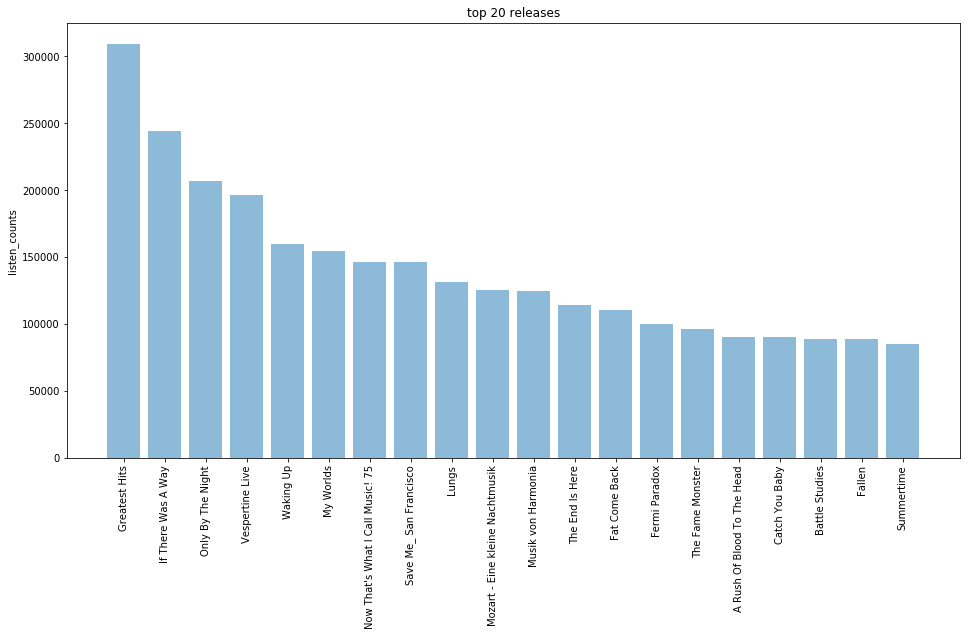

In [23]:
popular_release = triplet_dataset_sub_song_merged[['release','listen_count']].groupby('release').sum().reset_index()
popular_release_top_20 = popular_release.sort_values('listen_count', ascending=False).head(n=20)

objects = (list(popular_release_top_20['release']))
y_pos = np.arange(len(objects))
performance = list(popular_release_top_20['listen_count'])
 
plt.figure(figsize=(16,8)) 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('listen_counts')
plt.title('top 20 releases')
 
plt.show()

### 最流行歌手

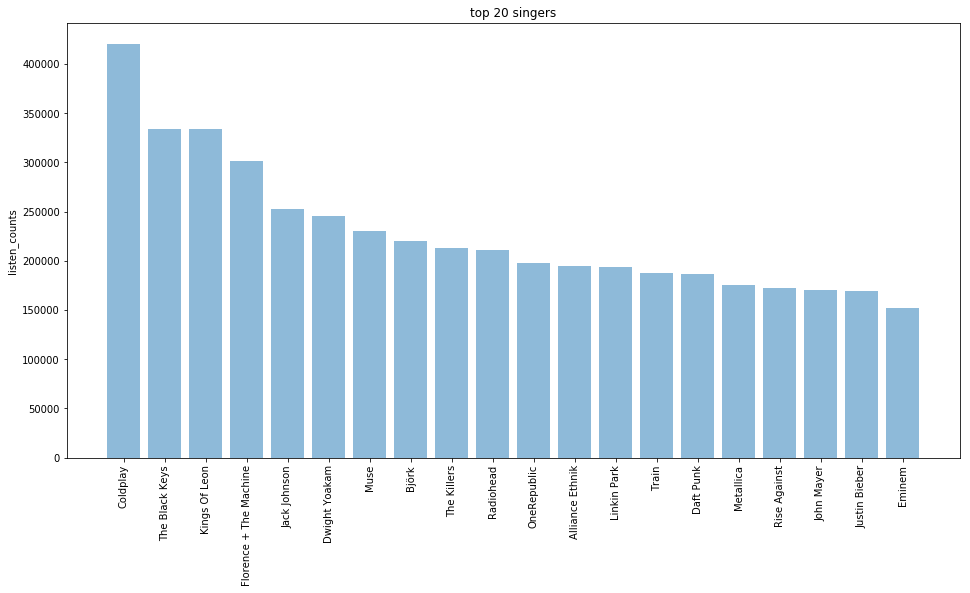

In [24]:
popular_artist = triplet_dataset_sub_song_merged[['artist_name','listen_count']].groupby('artist_name').sum().reset_index()
popular_artist_top_20 = popular_artist.sort_values('listen_count', ascending=False).head(n=20)

objects = (list(popular_artist_top_20['artist_name']))
y_pos = np.arange(len(objects))
performance = list(popular_artist_top_20['listen_count'])
 
plt.figure(figsize=(16,8)) 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('listen_counts')
plt.title('top 20 singers')
 
plt.show()

不过如果大家对这些音乐熟悉的话，可能会发现，虽然酷玩乐队(Coldplay)是最流行的乐队，但最热门的单曲中却没有他们的单曲。  
如果仔细研究一下的话，会发现他们每首单曲的播放量都很平均，因此他们的总播放量可以排名第一，但每首单曲都没有进前20。

### 用户单曲分布

In [25]:
# 这里我们使用的是`count`，而不是`sum`，所以得到的结果是用户听过的单曲数
user_song_count_distribution = triplet_dataset_sub_song_merged[['user','title']].groupby('user').count().reset_index().sort_values(by='title',ascending = False)
user_song_count_distribution.title.describe()

count    99996.000000
mean       112.355144
std         83.304243
min          1.000000
25%         55.000000
50%         93.000000
75%        147.000000
max       1241.000000
Name: title, dtype: float64

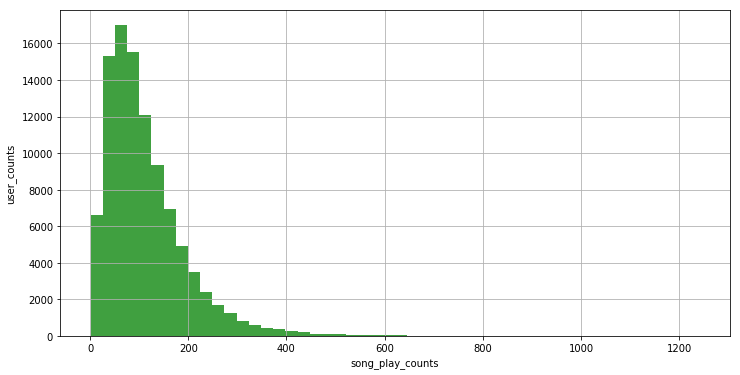

In [26]:
x = user_song_count_distribution.title
plt.figure(figsize=(12,6))
n, bins, patches = plt.hist(x, 50, facecolor='green', alpha=0.75)
plt.xlabel('song_play_counts')
plt.ylabel('user_counts')
plt.grid(True)

## 推荐引擎
推荐引擎要做的事情其实已经很明显了：推荐！  
推荐的办法有很多，最长被讨论的有如下三种：  
1. 基于用户的推荐引擎  
    这种推荐引擎中，用户是最为重要的实体。它的基本逻辑是寻找用户间的相似性，然后以此作为推荐的基础。
2. 基于内容的推荐引擎  
    在这种引擎中，很自然，内容是最为重要的实体，比如在我们这个案例中，歌曲就是核心。这种算法会去寻找内容的特征，然后建立内容间的相似性，基于这些相似性再做推荐  
3. 混合推荐引擎  
    这种其实也被称为协同过滤。
    
接下来的代码中会引用[https://github.com/llSourcell](https://github.com/llSourcell)中的代码。  
   
### 基于热度的推荐引擎
这种推荐引擎是最容易开发的。它的逻辑非常朴素：如果一样东西被很多人喜欢，那么推荐给更多的人一般来说也不会太坏。

In [27]:
import Recommenders as Recommenders # 改编自https://github.com/llSourcell
from sklearn.model_selection import train_test_split

In [28]:
train_data, test_data = train_test_split(triplet_dataset_sub_song_merged, test_size = 0.40, random_state=42)

In [29]:
train_data.head()

,user,song,listen_count,title,release,artist_name,year
724692,b1a37de85b16a6d54e41ae0a7072d21b64741718,SOIWBJU12A6701CBE7,1,Daft Punk Is Playing At My House,Daft Punk Is Playing At My House,LCD Soundsystem,2005
3113293,df2bbffa1462e857db63f92cc285353606be9f93,SOFKSRQ12A58A807B4,4,Skulls,Walk Among Us,The Misfits,1982
6204747,06f64e3bb87157d479adfa6abe359d888b5f39a1,SOKRGGA12A58A7D169,2,Plastic Cup Politics (Album Version),Anthem,Less Than Jake,2003
4764195,44e0bb621a201f8766a42cb9db2584648c482ef6,SOPPROJ12AB0184E18,5,Pursuit Of Happiness (nightmare),Pursuit Of Happiness,Kid Cudi / MGMT / Ratatat,2010
5613794,89511550bc2cc62b5eea6b4a455ba683f6d3cce8,SOUJVIT12A8C1451C1,6,Savior,Appeal To Reason,Rise Against,2008


In [30]:
def create_popularity_recommendation(train_data, user_id, item_id):
    train_data_grouped = train_data.groupby([item_id]).agg({user_id: 'count'}).reset_index()
    train_data_grouped.rename(columns = {user_id: 'score'},inplace=True)
    
    train_data_sort = train_data_grouped.sort_values(['score', item_id], ascending = [0,1])
    
    train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
    popularity_recommendations = train_data_sort.head(20)
    return popularity_recommendations

In [31]:
recommendations = create_popularity_recommendation(triplet_dataset_sub_song_merged,'user','title')
recommendations

,title,score,Rank
22710,Sehr kosmisch,18626,1.0
6722,Dog Days Are Over (Radio Edit),17635,2.0
31628,You're The One,16129,3.0
22662,Secrets,15138,4.0
21607,Revelry,14945,5.0
29070,Undo,14687,6.0
8759,Fireflies,13205,7.0
11162,Hey_ Soul Sister,12993,8.0
29233,Use Somebody,12793,9.0
11487,Horn Concerto No. 4 in E flat K495: II. Romanc...,12346,10.0


### 基于内容相似的推荐  
刚才我们开发了一个最简单的热榜推荐。现在我们来稍微开发一个更复杂一点的算法。  
我们要开发的这个算法是基于计算歌曲相似度的。我们这里采用的相似度也很简单：  
$$similarity_{ij}=\frac{intersection(users_i, users_j)}{union(users_i, users_j)}$$  
   
那么向用户k推荐歌曲的话，我们要做的是：  
1. 找出用户k听过的歌曲
2. 针对他听过的每首歌计算一下跟所有歌曲的相似度
3. 以相似度为准，找出相似度最高的歌曲并向用户推荐  
    
显然，这个算法的第2条是计算密集型的任务，当歌曲数目较多时，显然计算量非常大。所以这里我们再一次缩减曲库：

In [32]:
song_count_subset = song_count_df.head(n=5000) # 选择最流行的5000首歌
user_subset = list(play_count_subset.user)
song_subset = list(song_count_subset.song)
triplet_dataset_sub_song_merged_sub = triplet_dataset_sub_song_merged[triplet_dataset_sub_song_merged.song.isin(song_subset)]

In [33]:
triplet_dataset_sub_song_merged_sub.head()

,user,song,listen_count,title,release,artist_name,year
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,You And Me Jesus,Tribute To Jake Hess,Jake Hess,2004
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,Harder Better Faster Stronger,Discovery,Daft Punk,2007
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,Uprising,Uprising,Muse,0
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,Breakfast At Tiffany's,Home,Deep Blue Something,1993
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,Lucky (Album Version),We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0


In [34]:
train_data, test_data = train_test_split(triplet_dataset_sub_song_merged_sub, test_size = 0.30, random_state=42)
is_model = Recommenders.item_similarity_recommender_py()
is_model.create(train_data, 'user', 'title')

In [35]:
# 向用户推荐，即使5000篇，计算量也不小，大约需要1小时
user_id = list(train_data.user)[7]
user_items = is_model.get_user_items(user_id)
is_model.recommend(user_id)

No. of unique songs for the user: 66
no. of unique songs in the training set: 4879
Non zero values in cooccurence_matrix :290327


,user_id,song,score,rank
0,a974fc428825ed071281302d6976f59bfa95fe7e,Put Your Head On My Shoulder (Album Version),0.026334,1
1,a974fc428825ed071281302d6976f59bfa95fe7e,The Strength To Go On,0.025176,2
2,a974fc428825ed071281302d6976f59bfa95fe7e,Come Fly With Me (Album Version),0.024447,3
3,a974fc428825ed071281302d6976f59bfa95fe7e,Moondance (Album Version),0.024118,4
4,a974fc428825ed071281302d6976f59bfa95fe7e,Kotov Syndrome,0.023311,5
5,a974fc428825ed071281302d6976f59bfa95fe7e,Use Somebody,0.023104,6
6,a974fc428825ed071281302d6976f59bfa95fe7e,Lucky (Album Version),0.022930,7
7,a974fc428825ed071281302d6976f59bfa95fe7e,Secrets,0.022889,8
8,a974fc428825ed071281302d6976f59bfa95fe7e,Clocks,0.022562,9
9,a974fc428825ed071281302d6976f59bfa95fe7e,Sway (Album Version),0.022359,10


注意到，我们这里仅仅将歌曲的听众作为特征，并没有使用任何歌曲自身的特征，而实际上这些特征都可以用来定义歌曲之间的相似度。  
在现实的工业界场景中，相似度的衡量其实都是包含了非常多的各种各样的特征。

### 基于矩阵分解的推荐引擎

我们在理论课上讲过通过迭代的方式来求得内容的特征矩阵$X$和用户对这些特征兴趣的矩阵$\Theta$。当时我们也提到所谓的低秩矩阵分解的概念。当时我们的PPT中有这么一页内容：

|  |  张三(1) | 李四(2) | 王二(3) | 麻子(4) |
| --- | --- | --- | --- | --- |
| 泰坦尼克号 | 5 | 5 | 0 | 0 |
| 乱世佳人 | 5 | ? | ? | 0 |
| 罗马假日 | ? | 4 | 0 | ? |
| 无间道 | 0 | 0 | 5 | 4 |
| 指环王 | 0 | 0 | 5 | ? |

$$Y=\begin{bmatrix}5 & 5 & 0 & 0 \\ 
5 & ? & ? & 0 \\
? & 4 & 0 & ? \\ 
0 & 0 & 5 & 4 \\
0 & 0 & 5 & 0\end{bmatrix}$$  

预测评分：  

$$\begin{bmatrix}(\theta^{(1)})^T(x^{(1)}) & (\theta^{(2)})^T(x^{(1)}) & ... & (\theta^{(n_u)})^T(x^{(1)}) \\ 
(\theta^{(1)})^T(x^{(2)}) & (\theta^{(2)})^T(x^{(2)}) & ... & (\theta^{(n_u)})^T(x^{(2)}) \\ 
\vdots & \vdots & \vdots & \vdots \\
(\theta^{(1)})^T(x^{(n_m)}) & (\theta^{2)})^T(x^{(n_m)}) & ... & (\theta^{(n_u)})^T(x^{(n_m)}) 
\end{bmatrix}$$  
    
所以，$Y=X\Theta^T$  
   
既然得到了这个式子，那么我们其实可以利用线性代数的知识来直接求解，而不去迭代的来求解$X$和$\Theta$。当然了，考虑到矩阵分解的计算复杂度，我们在实际应用中其实更倾向于在理论课上讨论的迭代式的求解方式。    
    
这里我们作为扩展的内容，使用矩阵分解直接来试试。
对我们而言，我们目前所知道的矩阵分解其实只有在PCA降维的时候简单学习到的$SVD$分解。如果我们还记得使用$S$矩阵的前$K$个元素来挑选最重要的投影方向的话，我们其实也可以理解前$K$个元素对应的也是最重要的隐层特征。所以，我们可以借助$SVD$来构造这里的两个分解。那么基本的步骤是：  
1. 将用户播放矩阵进行$SVD$分解，得到$U, S, V$矩阵
2. 选择$S$的前$K$个元素(对角线)
3. 计算$S_k$的平方根得到$S_k^{1/2}$
4. 分别计算$U*S_k^{1/2}$和$S_k^{1/2}*V$作为用户喜好矩阵和内容特征矩阵

因为内存限制的原因，在运行下面的代码前最好 **"Restart"一下Kernel**

In [36]:
triplet_dataset_sub_song_merged = pd.read_csv('./data/triplet_dataset_sub_song_merged.csv',encoding='utf-8')

In [37]:
# 因为我们没有用户评分，只有用户播放的记录，因此我们使用用户播百分比作为评分
triplet_dataset_sub_song_merged_sum_df = triplet_dataset_sub_song_merged[['user','listen_count']].groupby('user').sum().reset_index()
triplet_dataset_sub_song_merged_sum_df.rename(columns={'listen_count':'total_listen_count'},inplace=True)
triplet_dataset_sub_song_merged = pd.merge(triplet_dataset_sub_song_merged,triplet_dataset_sub_song_merged_sum_df)
triplet_dataset_sub_song_merged['fractional_play_count'] = triplet_dataset_sub_song_merged['listen_count']/triplet_dataset_sub_song_merged['total_listen_count']

In [38]:
triplet_dataset_sub_song_merged[triplet_dataset_sub_song_merged.user =='d6589314c0a9bcbca4fee0c93b14bc402363afea'][['user','song','listen_count','fractional_play_count']].head()

,user,song,listen_count,fractional_play_count
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,0.036474
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,0.003040
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,0.003040
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,0.003040
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,0.021277


In [39]:
# 准备好 用户-歌曲 "评分"矩阵
from scipy.sparse import coo_matrix

small_set = triplet_dataset_sub_song_merged
user_codes = small_set.user.drop_duplicates().reset_index()
song_codes = small_set.song.drop_duplicates().reset_index()
user_codes.rename(columns={'index':'user_index'}, inplace=True)
song_codes.rename(columns={'index':'song_index'}, inplace=True)
song_codes['so_index_value'] = list(song_codes.index)
user_codes['us_index_value'] = list(user_codes.index)
small_set = pd.merge(small_set,song_codes,how='left')
small_set = pd.merge(small_set,user_codes,how='left')
mat_candidate = small_set[['us_index_value','so_index_value','fractional_play_count']]
data_array = mat_candidate.fractional_play_count.values
row_array = mat_candidate.us_index_value.values
col_array = mat_candidate.so_index_value.values

data_sparse = coo_matrix((data_array, (row_array, col_array)),dtype=float)

In [40]:
data_sparse

<99996x35000 sparse matrix of type '<class 'numpy.float64'>'
	with 11235065 stored elements in COOrdinate format>

In [41]:
user_codes[user_codes.user =='2a2f776cbac6df64d6cb505e7e834e01684673b6']

,user_index,user,us_index_value
27516,3109419,2a2f776cbac6df64d6cb505e7e834e01684673b6,27516


In [42]:
import math as mt
from scipy.sparse.linalg import * #used for matrix multiplication
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix

In [43]:
def compute_svd(urm, K):
    U, s, Vt = svds(urm, K)

    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = mt.sqrt(s[i]) # 求平方根

    U = csc_matrix(U, dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)
    
    return U, S, Vt

def compute_estimated_matrix(urm, U, S, Vt, uTest, K):
    rightTerm = S*Vt 
    max_recommendation = 250
    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    recomendRatings = np.zeros(shape=(MAX_UID,max_recommendation ), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        estimatedRatings[userTest, :] = prod.todense()
        recomendRatings[userTest, :] = (-estimatedRatings[userTest, :]).argsort()[:max_recommendation]
    return recomendRatings

In [44]:
K=50
urm = data_sparse
MAX_PID = urm.shape[1]
MAX_UID = urm.shape[0]

U, S, Vt = compute_svd(urm, K)

In [45]:
uTest = [4,5,6,7,8,873,23]

uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K)

In [47]:
for user in uTest:
    print("Recommendation for user with user id {}". format(user))
    rank_value = 1
    for i in uTest_recommended_items[user,0:10]:
        song_details = small_set[small_set.so_index_value == i].drop_duplicates('so_index_value')[['title','artist_name']]
        print("The number {} recommended song is {} BY {}".format(rank_value, list(song_details['title'])[0],list(song_details['artist_name'])[0]))
        rank_value+=1

Recommendation for user with user id 4
The number 1 recommended song is Fireflies BY Charttraxx Karaoke
The number 2 recommended song is Hey_ Soul Sister BY Train
The number 3 recommended song is OMG BY Usher featuring will.i.am
The number 4 recommended song is Lucky (Album Version) BY Jason Mraz & Colbie Caillat
The number 5 recommended song is Vanilla Twilight BY Owl City
The number 6 recommended song is Billionaire [feat. Bruno Mars]  (Explicit Album Version) BY Travie McCoy
The number 7 recommended song is Love Story BY Taylor Swift
The number 8 recommended song is Crumpshit BY Philippe Rochard
The number 9 recommended song is Jamaica Roots II(Agora E Sempre) BY Natiruts
The number 10 recommended song is Use Somebody BY Kings Of Leon
Recommendation for user with user id 5
The number 1 recommended song is Sehr kosmisch BY Harmonia
The number 2 recommended song is Dog Days Are Over (Radio Edit) BY Florence + The Machine
The number 3 recommended song is Ain't Misbehavin BY Sam Cooke
T

## 开源推荐引擎库
我们这里简单地实现了一个基于矩阵分解的推荐引擎，虽然非常简单，但希望能给大家一个简明的认识。  
当然，在python中也有一些开源的推荐引擎库：  
* scikit-surprise
* lightfm
* crab
* rec_sys
* ...